# 模型选择、欠拟合和过拟合

通过多项式拟合来交互地探索这些概念

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

使用以下三阶多项式来生成训练和测试数据的标签：
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

查看一下前2个样本

In [4]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[1.1335],
         [1.2009]]),
 tensor([[1.0000e+00, 1.1335e+00, 6.4237e-01, 2.4270e-01, 6.8773e-02, 1.5590e-02,
          2.9452e-03, 4.7689e-04, 6.7568e-05, 8.5095e-06, 9.6452e-07, 9.9386e-08,
          9.3875e-09, 8.1849e-10, 6.6267e-11, 5.0074e-12, 3.5473e-13, 2.3651e-14,
          1.4893e-15, 8.8847e-17],
         [1.0000e+00, 1.2009e+00, 7.2106e-01, 2.8863e-01, 8.6653e-02, 2.0812e-02,
          4.1655e-03, 7.1460e-04, 1.0727e-04, 1.4313e-05, 1.7188e-06, 1.8764e-07,
          1.8778e-08, 1.7346e-09, 1.4879e-10, 1.1912e-11, 8.9406e-13, 6.3157e-14,
          4.2135e-15, 2.6631e-16]]),
 tensor([5.5720, 5.6822]))

实现一个函数来评估模型在给定数据集上的损失

In [5]:
def evaluate_loss(net, data_iter, loss):  
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

定义训练函数

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.001)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

三阶多项式函数拟合(正态)

weight: [[ 5.00787    1.1926285 -3.3987024  5.6181626]]


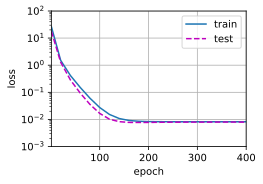

In [7]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

线性函数拟合(欠拟合)

weight: [[2.7043142 4.372263 ]]


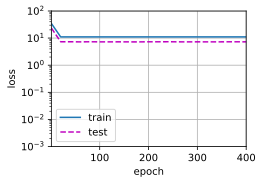

In [8]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

高阶多项式函数拟合(过拟合)

weight: [[ 4.989551    1.2833138  -3.315731    5.1762376  -0.28511187  1.1770252
   0.27893963  0.16344428  0.03016883  0.16155787 -0.20492388  0.10725393
  -0.08166032 -0.20680346  0.03457766 -0.21284607  0.21389215  0.1484564
   0.04669599  0.20451379]]


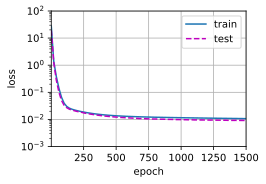

In [9]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)